In [1]:
import pandas as pd
import gc
sunat_train=pd.read_csv('../data/intermediate/sunat_train.csv', index_col = 'key_value')
sunat_test=pd.read_csv('../data/intermediate/sunat_test.csv', index_col = 'key_value')
censo_train=pd.read_csv('../data/intermediate/censo_train.csv', index_col = 'key_value')
censo_test=pd.read_csv('../data/intermediate/censo_test.csv', index_col = 'key_value')
se_train=pd.read_csv('../data/intermediate/se_train.csv', index_col = 'key_value')
se_test=pd.read_csv('../data/intermediate/se_test.csv', index_col = 'key_value')
rcc_train=pd.read_csv('../data/intermediate/rcc_train.csv', index_col = 'key_value')
rcc_test=pd.read_csv('../data/intermediate/rcc_test.csv', index_col = 'key_value')
y_train = pd.read_csv('../data/y_train.csv', index_col = 'key_value')

In [5]:
train = rcc_train.join(sunat_train).join(censo_train).join(se_train)
test = rcc_test.join(sunat_test).join(censo_test).join(se_test)
del rcc_train, sunat_train, censo_train, se_train, rcc_test, sunat_test, censo_test, se_test

In [7]:
keep_cols = list(set(train.columns).intersection(set(test.columns)))
train = train[keep_cols].copy()
test = test[keep_cols].copy()
len(set(train.columns) - set(test.columns)) , len(set(test.columns) - set(train.columns))

(0, 0)

In [8]:
import re
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_-]+', '', x))
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_-]+', '', x))

In [9]:
train.shape, test.shape

((358487, 423), (396666, 423))

In [13]:
#Función para obtener variables con alta correlación
def get_correlated(data, cut=0.85):
    correlated_features = set()
    correlation_matrix = data.corr()
    
    for i in range(len(correlation_matrix .columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > cut:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
            
    return correlated_features

correlated=get_correlated(train,cut=0.9)
train=train.drop(columns=correlated)
test= test.drop(columns=correlated)

In [10]:

# !pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]
    
    learner = CatBoostClassifier(n_estimators=1000, depth = 6, eval_metric = 'AUC' )
    learner.fit(Xt, yt,  early_stopping_rounds=10,
                eval_set=[(Xt, yt), (Xv, yv)], verbose=50)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
          
test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)

print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))

********** 0 **********
Learning rate set to 0.128212
0:	test: 0.7719351	test1: 0.7776888	best: 0.7776888 (0)	total: 328ms	remaining: 5m 27s
50:	test: 0.8441649	test1: 0.8436466	best: 0.8436466 (50)	total: 13.8s	remaining: 4m 16s
100:	test: 0.8551711	test1: 0.8533679	best: 0.8533679 (100)	total: 27s	remaining: 4m
150:	test: 0.8621038	test1: 0.8584098	best: 0.8584098 (150)	total: 39.9s	remaining: 3m 44s
200:	test: 0.8668263	test1: 0.8609768	best: 0.8609768 (200)	total: 52.5s	remaining: 3m 28s
250:	test: 0.8701976	test1: 0.8624172	best: 0.8624172 (250)	total: 1m 4s	remaining: 3m 12s
300:	test: 0.8730020	test1: 0.8633368	best: 0.8633368 (300)	total: 1m 16s	remaining: 2m 57s
350:	test: 0.8757292	test1: 0.8641373	best: 0.8641373 (350)	total: 1m 28s	remaining: 2m 44s
400:	test: 0.8780151	test1: 0.8646271	best: 0.8646327 (399)	total: 1m 40s	remaining: 2m 30s
450:	test: 0.8800055	test1: 0.8650634	best: 0.8650634 (450)	total: 1m 52s	remaining: 2m 16s
500:	test: 0.8820701	test1: 0.8655033	best: 

In [11]:
fi.sort_values(ascending=False).head(50)#.plot.bar(figsize=(15,10))

COD_CLASIFICACION_DEUDOR_5_ult1meses     0.242175
PRODUCTO_1_ult1meses                     0.046863
RIESGO_DIRECTO_2_ult1meses               0.024061
tipo_credito_11_ult1meses                0.023594
RIESGO_DIRECTO_-1_ult12meses             0.020768
COD_CLASIFICACION_DEUDOR_1_ult3meses     0.020171
PRODUCTO_8_ult12meses                    0.016683
matpar4                                  0.015890
cod_instit_financiera_32_ult6meses       0.015483
hig6                                     0.014597
COD_CLASIFICACION_DEUDOR_0_ult1meses     0.014344
PRODUCTO_0_ult6meses                     0.013857
PRODUCTO_3_ult6meses                     0.013134
tipo_credito_12_ult1meses                0.011626
edad                                     0.011025
tip_lvledu                               0.010455
tipo_credito_12_ult3meses                0.010264
cod_instit_financiera_61_ult1meses       0.009679
cod_instit_financiera_55_ult12meses      0.009525
PRODUCTO_6_ult12meses                    0.009067


In [12]:
test_probs.name = "target"
test_probs.to_csv("../results/test5.csv")

In [16]:
learner_ = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC' )
learner_.fit(train, y_train,  early_stopping_rounds=10, verbose = 50)

Learning rate set to 0.126968
0:	total: 311ms	remaining: 5m 10s
50:	total: 15.1s	remaining: 4m 41s
100:	total: 29.5s	remaining: 4m 22s
150:	total: 43.7s	remaining: 4m 5s
200:	total: 58s	remaining: 3m 50s
250:	total: 1m 11s	remaining: 3m 32s
300:	total: 1m 24s	remaining: 3m 15s
350:	total: 1m 36s	remaining: 2m 57s
400:	total: 1m 49s	remaining: 2m 43s
450:	total: 2m 1s	remaining: 2m 28s
500:	total: 2m 14s	remaining: 2m 13s
550:	total: 2m 27s	remaining: 1m 59s
600:	total: 2m 40s	remaining: 1m 46s
650:	total: 2m 53s	remaining: 1m 32s
700:	total: 3m 5s	remaining: 1m 19s
750:	total: 3m 18s	remaining: 1m 5s
800:	total: 3m 30s	remaining: 52.3s
850:	total: 3m 42s	remaining: 39s
900:	total: 3m 55s	remaining: 25.8s
950:	total: 4m 7s	remaining: 12.8s
999:	total: 4m 19s	remaining: 0us


In [17]:
fi_ = pd.Series(learner_.feature_importances_ / learner_.feature_importances_.sum(), index=train.columns)
fi_.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_ult1meses    0.218058
PRODUCTO_1_ult1meses                    0.048196
agudia2                                 0.029495
tipo_credito_11_ult1meses               0.024733
matpar6                                 0.024339
RIESGO_DIRECTO_-1_ult12meses            0.020225
PRODUCTO_0_ult6meses                    0.017559
profe_9                                 0.017491
RIESGO_DIRECTO_2_ult1meses              0.017163
COD_CLASIFICACION_DEUDOR_1_ult3meses    0.016437
PRODUCTO_8_ult12meses                   0.016366
cod_instit_financiera_32_ult6meses      0.015005
PRODUCTO_3_ult6meses                    0.013838
COD_CLASIFICACION_DEUDOR_0_ult1meses    0.013645
tipo_credito_12_ult1meses               0.013333
edad                                    0.012803
acteco4                                 0.012589
tip_lvledu                              0.010941
cod_instit_financiera_55_ult12meses     0.010147
cod_instit_financiera_61_ult1meses      0.009993
cod_instit_financier

In [18]:
test_probs_ = pd.Series(learner_.predict_proba(test)[:, -1], index=test.index, name="target")

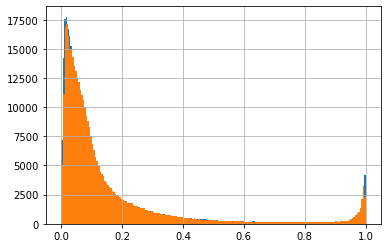

In [19]:
test_probs_.hist(bins = 200)
test_probs.hist(bins = 200)

In [21]:
test_probs_.name = "target"
test_probs_.to_csv("../results/test5_v2.csv")